In [25]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import cv2

In [13]:
class GAN(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.G = Generator(device=device)
        self.D = Discriminator(device=device)
    def forward(self, x):
        x = self.G(x)
        y = self.D(x)
        return y
class Discriminator(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2),  padding=1)
        self.relu1 = nn.LeakyReLU(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2),  padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.2)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv3 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2),  padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU(0.2)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64*4*4, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.relu4 = nn.LeakyReLU(0.2)
        self.out = nn.Linear(64, 1)
    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        h = self.relu3(h)
        h = self.pool3(h)
        h = self.flatten(h)
        h = self.fc(h)
        h = self.bn4(h)
        h = self.relu4(h)
        h = self.out(h)
        y = torch.sigmoid(h)
        return y
class Generator(nn.Module):
    def __init__(self, input_dim=100, device='cpu'):
        super().__init__()
        self.device = device
        self.linear = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.conv1t= nn.ConvTranspose2d(16, 256, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()
        self.conv2t= nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
                
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv3t= nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.conv4t= nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()
        self.conv5t= nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)

        self.bn6 = nn.BatchNorm2d(16)
        self.relu6 = nn.ReLU()
        self.conv6t= nn.ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)

    def forward(self, x):
        h = self.linear(x)
        h = self.bn1(h)
        h = self.relu1(h)
        
        h = h.view(-1, 16, 4, 4)
        h = self.conv1t(h)
        
        h = self.bn2(h)
        h = self.relu2(h)
        h = self.conv2t(h)
        
        h = self.bn3(h)
        h = self.relu3(h)
        h = self.conv3t(h)
        
        h = self.bn4(h)
        h = self.relu4(h)
        h = self.conv4t(h)
        
        h = self.bn5(h)
        h = self.relu5(h)
        h = self.conv5t(h)
        
        h = self.bn6(h)
        h = self.relu6(h)
        h = self.conv6t(h)
        y = torch.sigmoid(h)

        return y

In [16]:
data_dir = 'bottle/train'
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 画像のリサイズ
    transforms.ToTensor()])
dataset = ImageFolder(root=data_dir, transform=transform)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
if __name__ == '__main__':
    model = GAN(device=device).to(device)
    def gen_noise(batch_size):
        return torch.empty(batch_size, 100).uniform_(0, 1).to(device)
    criterion = nn.BCELoss()
    optimizer_D = optimizers.Adam(model.D.parameters(), lr=0.0002)
    optimizer_G = optimizers.Adam(model.G.parameters(), lr=0.0002)
    def compute_loss(label, preds):
        return criterion(preds, label)
    def train_step(x):
        batch_size = x.size(0)
        model.D.train()
        model.G.train()
        # 識別器の訓練
        #本物画像
        preds = model.D(x).squeeze() # 本物画像に対する予測
        t = torch.ones(batch_size).float().to(device)
        loss_D_real = compute_loss(t, preds)
        # 偽物画像
        noise = gen_noise(batch_size)
        gen = model.G(noise)
        preds = model.D(gen.detach()).squeeze() # 偽物画像に対する予測
        t = torch.zeros(batch_size).float().to(device)
        loss_D_fake = compute_loss(t, preds)
        loss_D = loss_D_real + loss_D_fake
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        # 生成器の訓練
        # 生成器の訓練
        noise = gen_noise(batch_size)
        gen = model.G(noise)
        preds = model.D(gen).squeeze() # 偽物画像に対する予測
        t = torch.ones(batch_size).float().to(device) # 偽物画像のラベルを「本物画像」に
        loss_G = compute_loss(t, preds)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        return loss_D, loss_G
    
    epochs = 500
    for epoch in range(epochs):
        train_loss_D = 0.
        train_loss_G = 0.
        test_loss = 0.
        for (x, _) in dataloader:
            x = x.to(device)
            loss_D, loss_G = train_step(x)
            train_loss_D += loss_D.item()
            train_loss_G += loss_G.item()
            train_loss_D /= len(dataloader)
            train_loss_G /= len(dataloader)
        print('Epoch: {}, D loss: {:.3f}, G loss: {:.3f}'.format(epoch+1,train_loss_D,train_loss_G))

Epoch: 1, D loss: 0.236, G loss: 0.100
Epoch: 2, D loss: 0.237, G loss: 0.102
Epoch: 3, D loss: 0.230, G loss: 0.104
Epoch: 4, D loss: 0.229, G loss: 0.108
Epoch: 5, D loss: 0.231, G loss: 0.108
Epoch: 6, D loss: 0.228, G loss: 0.112
Epoch: 7, D loss: 0.227, G loss: 0.113
Epoch: 8, D loss: 0.226, G loss: 0.114
Epoch: 9, D loss: 0.226, G loss: 0.115
Epoch: 10, D loss: 0.223, G loss: 0.117
Epoch: 11, D loss: 0.223, G loss: 0.119
Epoch: 12, D loss: 0.220, G loss: 0.120
Epoch: 13, D loss: 0.224, G loss: 0.121
Epoch: 14, D loss: 0.225, G loss: 0.121
Epoch: 15, D loss: 0.220, G loss: 0.122
Epoch: 16, D loss: 0.219, G loss: 0.123
Epoch: 17, D loss: 0.217, G loss: 0.123
Epoch: 18, D loss: 0.216, G loss: 0.124
Epoch: 19, D loss: 0.220, G loss: 0.125
Epoch: 20, D loss: 0.219, G loss: 0.126
Epoch: 21, D loss: 0.213, G loss: 0.126
Epoch: 22, D loss: 0.215, G loss: 0.126
Epoch: 23, D loss: 0.213, G loss: 0.125
Epoch: 24, D loss: 0.211, G loss: 0.126
Epoch: 25, D loss: 0.216, G loss: 0.128
Epoch: 26

Epoch: 204, D loss: 0.114, G loss: 0.229
Epoch: 205, D loss: 0.150, G loss: 0.228
Epoch: 206, D loss: 0.132, G loss: 0.226
Epoch: 207, D loss: 0.141, G loss: 0.223
Epoch: 208, D loss: 0.117, G loss: 0.225
Epoch: 209, D loss: 0.103, G loss: 0.223
Epoch: 210, D loss: 0.116, G loss: 0.231
Epoch: 211, D loss: 0.096, G loss: 0.234
Epoch: 212, D loss: 0.100, G loss: 0.230
Epoch: 213, D loss: 0.162, G loss: 0.234
Epoch: 214, D loss: 0.104, G loss: 0.237
Epoch: 215, D loss: 0.148, G loss: 0.230
Epoch: 216, D loss: 0.108, G loss: 0.231
Epoch: 217, D loss: 0.123, G loss: 0.233
Epoch: 218, D loss: 0.138, G loss: 0.237
Epoch: 219, D loss: 0.137, G loss: 0.237
Epoch: 220, D loss: 0.122, G loss: 0.233
Epoch: 221, D loss: 0.128, G loss: 0.233
Epoch: 222, D loss: 0.107, G loss: 0.240
Epoch: 223, D loss: 0.108, G loss: 0.229
Epoch: 224, D loss: 0.087, G loss: 0.241
Epoch: 225, D loss: 0.156, G loss: 0.247
Epoch: 226, D loss: 0.110, G loss: 0.241
Epoch: 227, D loss: 0.158, G loss: 0.247
Epoch: 228, D lo

Epoch: 404, D loss: 0.067, G loss: 0.280
Epoch: 405, D loss: 0.078, G loss: 0.271
Epoch: 406, D loss: 0.066, G loss: 0.280
Epoch: 407, D loss: 0.070, G loss: 0.321
Epoch: 408, D loss: 0.091, G loss: 0.308
Epoch: 409, D loss: 0.184, G loss: 0.304
Epoch: 410, D loss: 0.065, G loss: 0.323
Epoch: 411, D loss: 0.067, G loss: 0.303
Epoch: 412, D loss: 0.163, G loss: 0.281
Epoch: 413, D loss: 0.075, G loss: 0.329
Epoch: 414, D loss: 0.116, G loss: 0.317
Epoch: 415, D loss: 0.126, G loss: 0.305
Epoch: 416, D loss: 0.084, G loss: 0.299
Epoch: 417, D loss: 0.090, G loss: 0.319
Epoch: 418, D loss: 0.081, G loss: 0.313
Epoch: 419, D loss: 0.059, G loss: 0.314
Epoch: 420, D loss: 0.078, G loss: 0.314
Epoch: 421, D loss: 0.065, G loss: 0.317
Epoch: 422, D loss: 0.118, G loss: 0.328
Epoch: 423, D loss: 0.167, G loss: 0.325
Epoch: 424, D loss: 0.097, G loss: 0.306
Epoch: 425, D loss: 0.074, G loss: 0.318
Epoch: 426, D loss: 0.110, G loss: 0.294
Epoch: 427, D loss: 0.162, G loss: 0.326
Epoch: 428, D lo

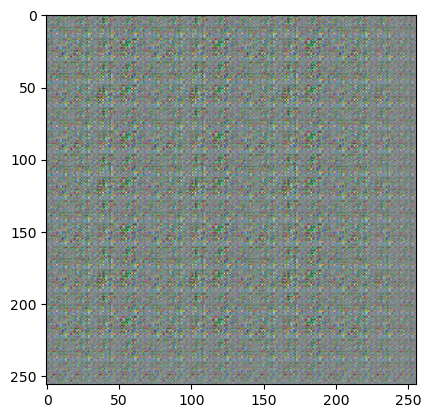

In [22]:
def imshow(img):
    img = img / torch.max(img)*255
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def generate(batch_size=100):
    model.eval()
    noise = gen_noise(batch_size)
    gen = model.G(noise)
    return gen
images = generate(batch_size=100)
img = images.squeeze().detach().cpu()
img = img / torch.max(img)*255
npimg = img.numpy()
npimg = np.transpose(npimg, (0, 2, 3, 1))
npimg = npimg.astype('i8')
# plt.imshow(npimg[0])
# plt.imshow(np.transpose(npimg, (1, 2, 0)))
# imshow(torchvision.utils.make_grid(images))

In [21]:
npimg

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [26]:
def save(fake):
    dir_name = 'torch_epoch200'
    dir_path = 'gan_train/'+dir_name
#     os.makedirs(dir_path)
    for i in range(len(fake)):
        cv2.imwrite(dir_path+'/'+str(i)+'.png', fake[i])
save(npimg)